**кластеризация методом k-means**

Евгений Борисов esborisov@sevsu.ru

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
from sklearn.datasets import make_blobs

In [3]:
n_samples = 500
n_clst = 4 # количество кластеров

X,_ = make_blobs( 
        n_samples=n_samples,
        centers=n_clst,  
        cluster_std=rng.uniform(size=n_clst)+.7
    )
X.shape

(500, 2)

In [4]:
# инициализация параметров
# mu = rng.normal(size=(n_clst,X.shape[1]),scale=X.max(axis=0)*.75)
mu = rng.normal(size=(n_clst,X.shape[1]),scale=.1) + X.mean(axis=0) 
mu

array([[-3.05696875, -1.6995723 ],
       [-3.04349978, -1.69342343],
       [-2.9625219 , -1.5055114 ],
       [-3.02401594, -1.68212866]])

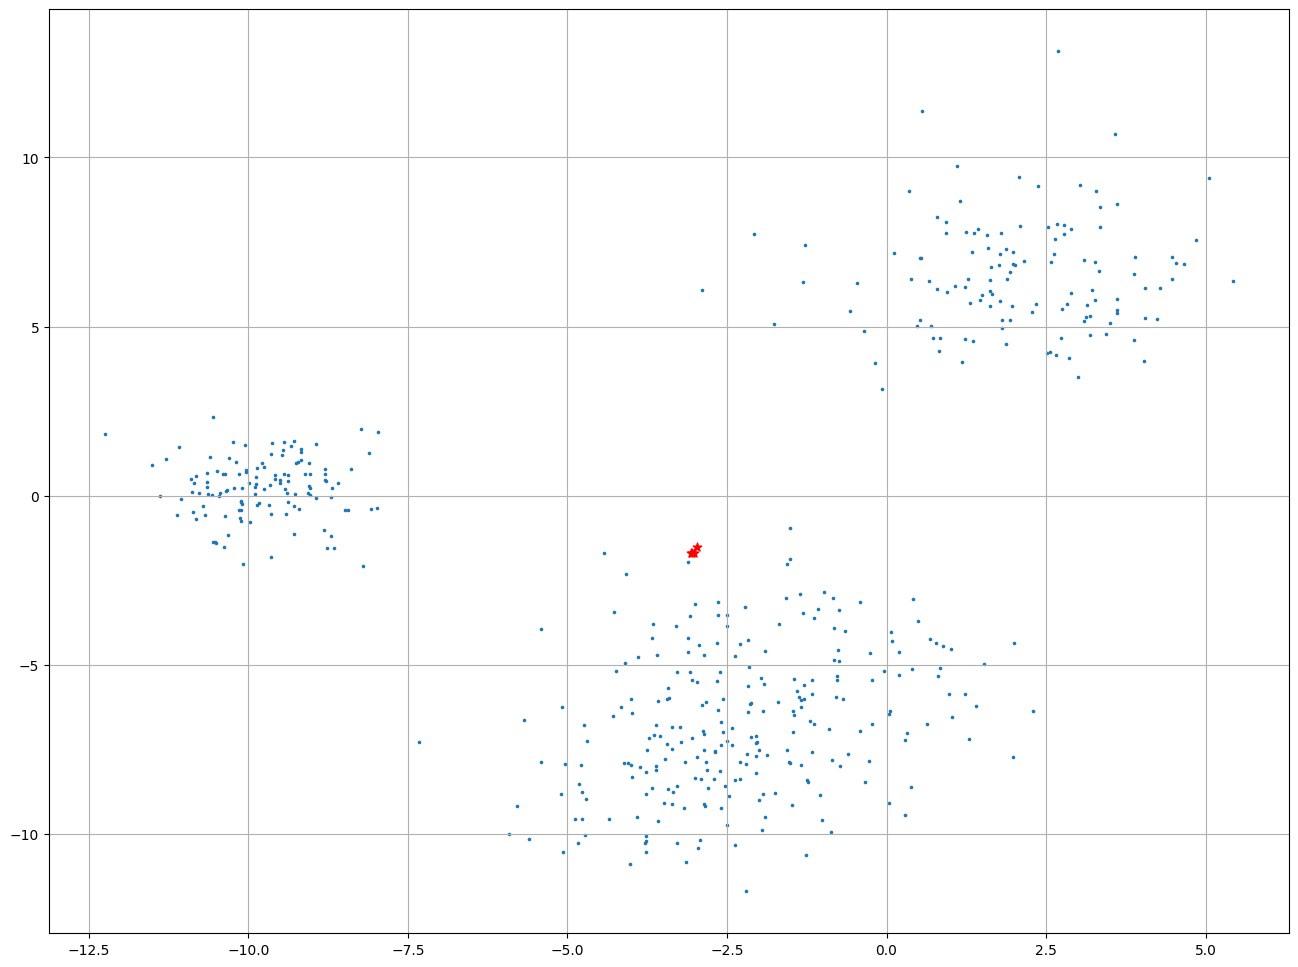

In [5]:
def plot(X,mu):
    plt.figure(figsize=(16,12))
    plt.scatter( x=X[:,0], y=X[:,1], s=10, marker='.' )
    plt.scatter( x=mu[:,0], y=mu[:,1], s=40, marker='*',c='r' )
    plt.grid()

plot(X,mu)

In [6]:
def get_labels(X,mu): # сформировать кластеры
    d = euclidean_distances(X,mu) # расстояния от центроидов до всех точек 
    return np.argmin(d,axis=1) # номера кластеров (ближайших центроидов) всех для точек

def move_centroid(X,mu,y): # пересчитываем центроиды
    return np.vstack([ 
        X[(y==j)].mean(axis=0) # пересчитываем центроид для кластера j
        if len(X[(y==j)])>0 # если кластер пустой
        else mu[j] # то оставляем старый центроид
        for j in set(y) # для всех меток кластеров
    ])

def kmeans(X,mu,min_delta_mu=1e-10,n_epoch=100):
    for _ in range(n_epoch):
        y = get_labels(X,mu) # сформировать кластеры
        mu_prev = mu # сохранить старые центроиды
        mu = move_centroid(X,mu,y) # пересчитать центроиды
        # проверяем среднее смещение центроидов
        if (np.diag(euclidean_distances(mu,mu_prev)).sum()/len(mu))<min_delta_mu: 
            break
    return mu, get_labels(X,mu)

In [7]:
mu,y = kmeans(X,mu)

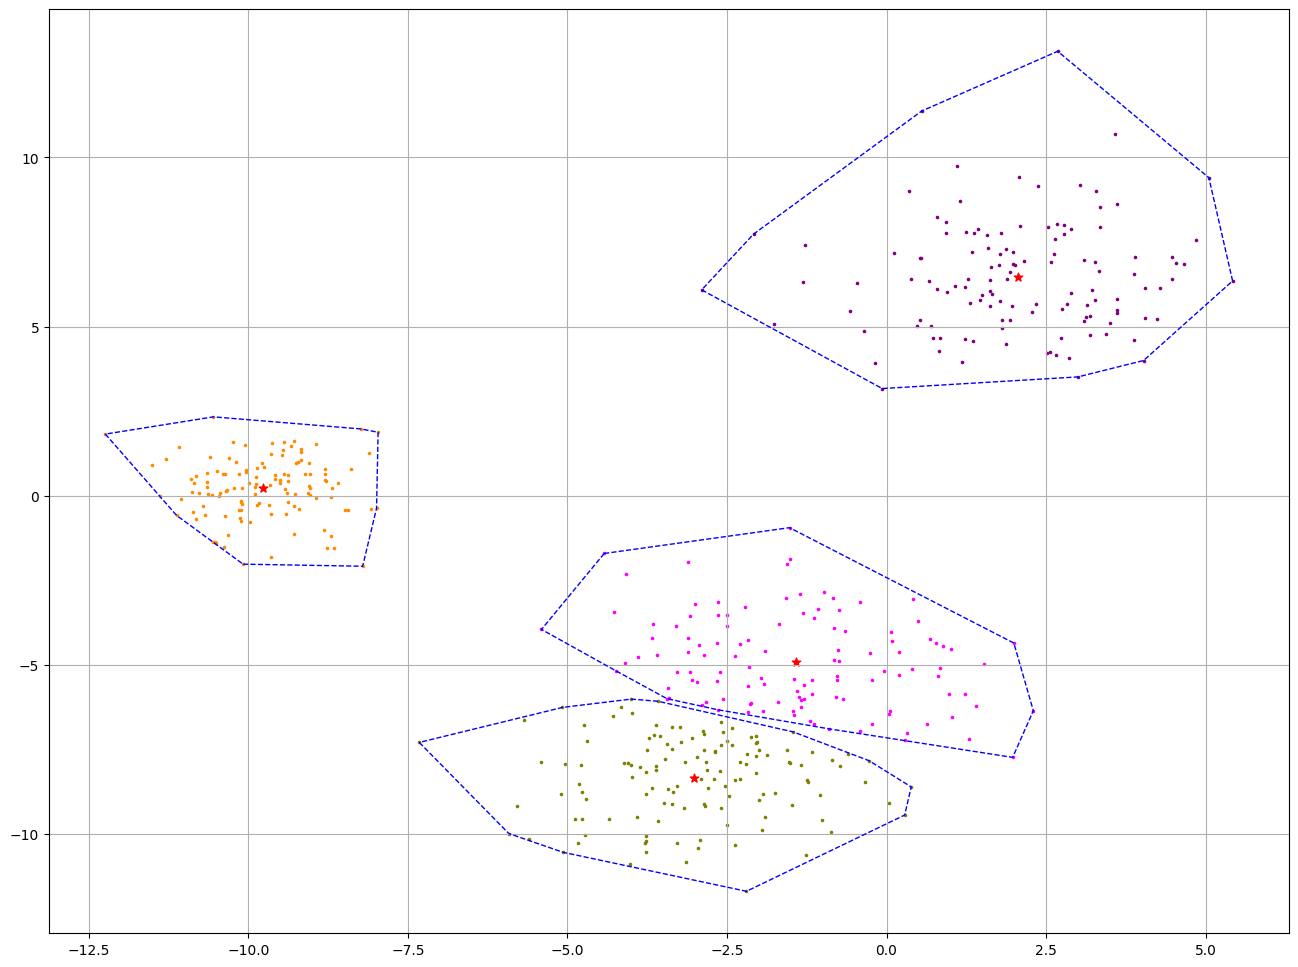

In [8]:
from scipy.spatial import ConvexHull

def color(i):
    c = ['darkorange','olive','purple','magenta','crimson','chokolade','seagreen']
    return c[i] if i<len(c) else 'blue'

def hull(x):
    hull = ConvexHull(x) # рисуем выпуклую оболочку вокруг кластера
    v = np.append( hull.vertices, hull.vertices[0] ) # замыкаем оболочку
    plt.plot(x[v,0],x[v,1],'--',lw=1,c='b')

def plot(X,mu,y,figsize=(16,12)):
    plt.figure(figsize=figsize)
    colors = rng.uniform(size=(len(set(y)),3),low=.3,high=1.)
    for j in set(y): 
        plt.scatter( x=X[y==j,0], y=X[y==j,1], s=10, marker='.',c=color(j) )
        plt.scatter( x=mu[j,0], y=mu[j,1], s=40, marker='*',c='r' )
        hull(X[y==j])
    plt.grid()

    
plot(X,mu,y)

---

In [9]:
# оценка результата
from sklearn.metrics import silhouette_score

# отношение внутрикластерного и межкластерного расстояний
silhouette_score(X,y)

0.611014403739733